In [ ]:
import os
import getpass

from langchain_community.tools.google_scholar import GoogleScholarQueryRun
from langchain_community.utilities.google_scholar import GoogleScholarAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

os.environ["SERP_API_KEY"] = getpass.getpass("Serp API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [11]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - BSCapture - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

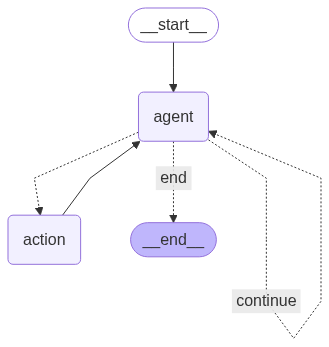

In [40]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools.google_scholar import GoogleScholarQueryRun
from langchain_community.utilities.google_scholar import GoogleScholarAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Model definition (must be defined before tools that use it)
model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

# Tool definitions
google_scholar_tool = GoogleScholarQueryRun(api_wrapper=GoogleScholarAPIWrapper())
tavily_tool = TavilySearchResults(max_results=10)
arxiv_tool = ArxivQueryRun()

# Compose tool belt: all must be LC tool objects or callables with correct signature
tool_belt = [
    tavily_tool,
    arxiv_tool,
    google_scholar_tool
]

# Bind tools to model (for tool calling)
model = model.bind_tools(tool_belt)

# Agent state definition
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

# Model call node: expects state with "messages", returns dict with "messages" (list of BaseMessage)
def call_model(state: AgentState):
    messages = state["messages"]
    response = model.invoke(messages, config={"recursion_limit": 10})
    return {"messages" : [response]}

# Tool node: ToolNode expects a list of tools/callables
tool_node = ToolNode(tool_belt)


def is_grounded(state: AgentState):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"

    initial_query = state["messages"][0]
    final_response = state["messages"][-1]

    if len(state["messages"]) > 10:
        return "END"
    
    prompt_template = """\
    Given an initial query and a final response, determine if the response is scientificly grounded or not.
     
    Please indicate scientific groundedness with a 'Y' and ungroundedness as an 'N'.

    Initial Query:
    {initial_query}

    Final Response:
    {final_response}"""

    groundedness_prompt_template = PromptTemplate.from_template(prompt_template)
    groundedness_check_model = ChatOpenAI(model="gpt-4.1-mini")
    groundedness_chain = groundedness_prompt_template | groundedness_check_model | StrOutputParser()
    groundedness_response = groundedness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

    if "Y" in groundedness_response:
        return "end"
    
    return "continue"


# Graph definition
uncompiled_graph = StateGraph(AgentState)
uncompiled_graph.set_entry_point("agent")
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)
# The "action" node is not added to the graph, so "should_continue" cannot route to it.
# To ensure "should_continue" is represented in the graph, add the "action" node and its edge:
uncompiled_graph.add_conditional_edges(
    "agent", is_grounded, {
        "continue": "agent",
        "action": "action",
        "end": END
    }
)
uncompiled_graph.add_edge("action", "agent")

simple_agent_graph = uncompiled_graph.compile()
simple_agent_graph

In [41]:
from langchain_core.messages import HumanMessage

input_text = "WIll the blex product from rednatura works for the benefits they advertise?"
inputs = {
    "messages": [
        SystemMessage(content="You are a cautious, evidence-driven health-product analyst assisting a user who is highly skeptical of advertising claims."),
        HumanMessage(content=input_text)
    ]
}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yOQ59QlPA37525PeWtfsII1g', 'function': {'arguments': '{"query": "Rednatura Blex product ingredients and scientific evidence for claimed benefits"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_RML7UYOgOy2AJqDopIRtNjPV', 'function': {'arguments': '{"query": "scientific studies on Blex from Rednatura"}', 'name': 'google_scholar'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 234, 'total_tokens': 305, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsYLKezWzykF6SkiAKN6bXY6JT5UI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs'

In [42]:
def convert_inputs(input_object):
    return {"messages": [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
    return input_state["messages"][-1].content

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

In [43]:
answer = agent_chain_with_formatting.invoke(
    {
        "question": "WIll the blex product from rednatura works for the benefits they advertise?"
    }
)
from IPython.display import Markdown, display
display(Markdown(answer))

I found some scientific literature and reviews regarding the Rednatura Blex product. The scientific articles do not specifically evaluate the product but discuss related topics such as sustainability and genetic structure of certain species. 

The reviews and product descriptions from various sources indicate that Blex from Rednatura is marketed as a supplement that supports joint health, flexibility, and reduces inflammation. The reviews suggest that users find it easy to consume and effective for their needs, with some noting benefits in joint mobility and pain relief.

However, there is no direct scientific evidence from peer-reviewed studies in my search results that conclusively proves the advertised benefits of the product. The effectiveness of dietary supplements like Blex can vary among individuals, and it is advisable to consult with a healthcare professional before starting any new supplement regimen.

Would you like more detailed information on specific ingredients or scientific studies?